<a href="https://colab.research.google.com/github/pkalnins/network_pharmacology/blob/main/Network_Pharmacology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Network Pharmacology-Based Analysis of the Role of Traditional Chinese Herbal Medicines in the Treatment of Migraine

- Paul Kalnins, ND, MS



### Project Overview
**Description:**
- This project explores how traditional Chinese herbal medicines might exert therapeutic effects on migraine by leveraging a network pharmacology approach.
- Recognizing the polygenic and multifactorial nature of migraine, the analysis integrates bioinformatics tools and databases to map known herbal constituents to migraine-relevant gene targets.

**Objectives:**
- Identify herbs commonly used in Chinese medicine for migraine treatment.
- Collect gene/protein targets for these herbs using the **ETCM** and **Batman2.0** databases.
- Retrieve migraine-associated genes from **DisGeNET**.
- Identify overlapping targets and construct a protein–protein interaction (PPI) network using STRING.
- Analyze network topology using betweenness centrality and Markov clustering to detect key targets and modules.
- Perform pathway enrichment using **ShinyGO** and **Reactome**.

**Key Findings:**
- Chinese herbs relevant to migraine modulate networks involving neurotransmitter (serotonin, dopamine, GABA, glutamate), inflammatory, vascular, and estrogen signaling pathways.
- Several clusters were identified in the PPI network, each corresponding to major biological pathways involved in migraine.
- Network metrics like betweenness centrality helped pinpoint central genes, suggesting potential mechanisms of action.

**Limitations:**
- Target predictions from herbal databases may lack bioavailability and binding specificity information.
- Current analyses do not distinguish between upregulation and inhibition of targets.
- Additional validation and methodological refinement are needed to confirm the utility of the selected network metrics.

**Note:**
- See accompanying slides for more details. The code used for analysis is show below.


In [ ]:
import os
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2
import networkx as nx


#### Load & Prepare Data

Here I gather herb-constituent and herb-target information from 2 databases (Batman2.0 and Encyclopedia of Traditional Chinese Medicine (ETCM)). I have downloaded the information from each database into text files, and then use the code below to parse the files for the relevant information.  

- Batman2.0: http://bionet.ncpsb.org.cn/batman-tcm/#/home
- Encyclopedia of Traditional Chinese Mediicne (ETCM): http://www.tcmip.cn/ETCM/

Also below I gather migraine targets from the disgenet.org database

- Disgenet.org: https://www.disgenet.org/


***

##### Load Batman 2.0 files


In [ ]:
def read_batman_file(filename):
    batman_dict = {}

    with open(filename, 'r') as file:
        next(file)  # Skip header
        for line in file:
            columns = line.strip().split('\t')
            compound_name = columns[0]
            compounds = []
            for c in range(2, len(columns)):
                gene_info = columns[c].strip().split('|')
                gene_name = gene_info[1].split('(')[0]
                compounds.append(gene_name)
            batman_dict[compound_name] = compounds

    return batman_dict

def get_batman_targets(batman_dict):
    batman_targets = []

    for value in batman_dict.values():
        for gene in value:
            batman_targets.append(gene)

    batman_targets = set(batman_targets)  # Find unique targets only (no repeats)
    batman_targets = {x for x in batman_targets if x != ''}  # Eliminate NA values

    return batman_targets

filename = './data/Batman_herb_data/batman_herb_data.txt'
batman_dict = read_batman_file(filename)
batman_targets = get_batman_targets(batman_dict)

print(f'Number of Batman2.0 targets: {len(batman_targets)}')


Number of Batman2.0 targets: 6587


***

##### Load Migraine Targets

- Obtained from disgenet.org database ('Common migraine')
- Write genes to a text file (to be loaded into STRING to make a PPI network if needed)

In [ ]:
def process_migraine_genes(input_csv, output_txt):
    df_migraine = pd.read_csv(input_csv)
    migraine_targets = set(df_migraine.iloc[:, 2].tolist())

    with open(output_txt, 'w') as file:
        for gene in migraine_targets:
            file.write(gene + '\n')

    print("Migraine targets have been written to", output_txt)
    print(f'Number of migraine targets: {len(migraine_targets)}')
    return migraine_targets

input_csv = './data/Disgenet_migraine_data/disgenet_migraine_targets.csv'
output_txt = './data//Disgenet_migraine_data/disgenet_migraine_targets.txt'

migraine_targets = process_migraine_genes(input_csv, output_txt)


Migraine targets have been written to ./data//Disgenet_migraine_data/disgenet_migraine_targets.txt
Number of migraine targets: 512


***

##### Gather ETCM Herb Data

This process was more complicted: I was only able to download separate files for each of the 9 herbs examined.  I had to parse each file for the relevant information.  

In [ ]:
def process_ETCM_data(folder_path):
    herb_dict = {}
    ETCM_targets = []
    ETCM_constituents = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            herb_name = file_name.split('_')[-1].split('.')[0]
            file_path = os.path.join(folder_path, file_name)
            herb_df = pd.read_csv(file_path, names=['Col1', 'Col2'])
            constituents = herb_df.iloc[12, 1:].tolist()[0].split(',')
            targets = herb_df.iloc[17, 1:].tolist()[0].split(';')

            # Check if herb_name already exists in herb_dict
            if herb_name not in herb_dict:
                herb_dict[herb_name] = {'constituents': [], 'targets': []}

            # Assign constituents and targets to the herb_dict
            herb_dict[herb_name]['constituents'] = constituents
            herb_dict[herb_name]['targets'] = targets

            # Extend ETCM_targets and ETCM_constituents
            ETCM_targets.extend(targets)
            ETCM_constituents.extend(constituents)

    ETCM_targets = list(set([item.strip() for item in ETCM_targets]))
    ETCM_constituents = list(set(ETCM_constituents))

    return herb_dict, ETCM_targets, ETCM_constituents

folder_path = "./data/ETCM_herb_data"
ETCM_dict, ETCM_targets, ETCM_constituents = process_ETCM_data(folder_path)


print("Number of herbs in ETCM_dict:", len(ETCM_dict))
print("Number of ETCM targets:", len(ETCM_targets))
print("Number of ETCM constituents:", len(ETCM_constituents))


Number of herbs in ETCM_dict: 9
Number of ETCM targets: 743
Number of ETCM constituents: 506


***

#### Create Venn Diagrams

- Will use the "overlap target" list from the migraine and both Batman2.0 and ETCM herb targets to compare

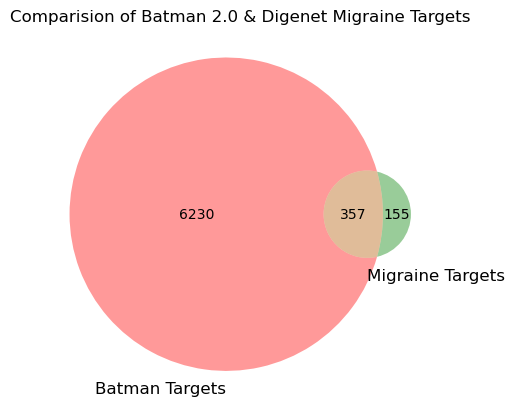

In [ ]:
venn2([set(batman_targets), set(migraine_targets)], ('Batman Targets', 'Migraine Targets'))
plt.title("Comparision of Batman 2.0 & Digenet Migraine Targets")
plt.show()

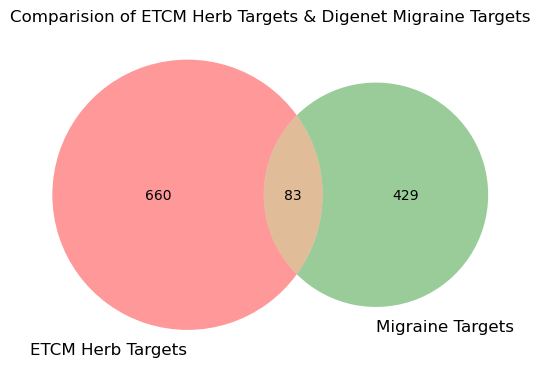

In [ ]:
venn2([set(ETCM_targets), set(migraine_targets)], ('ETCM Herb Targets', 'Migraine Targets'))
plt.title("Comparision of ETCM Herb Targets & Digenet Migraine Targets")
plt.show()

In [ ]:
def write_overlap_genes(list1, list2, output_file):
    set1 = set(list1)
    set2 = set(list2)
    intersection_set = set1.intersection(set2)
    overlapping_genes = list(intersection_set)

    with open(output_file, 'w') as file:
        for gene in overlapping_genes:
            file.write(gene + '\n')

    print(f'Overlap genes have been written to {output_file}')
    return(overlapping_genes)

output_file = './OT_analysis/ETCM_migraine_targets.txt'
OT_genes = write_overlap_genes(ETCM_targets, migraine_targets, output_file)


Overlap genes have been written to ./OT_analysis/ETCM_migraine_targets.txt


***

#### PPI Network

Next I input the overlap gene list ('OT_genes') into STRING (https://string-db.org/) to create a PPI network.  Below, I upload the gene pairs from the network as given by string for further analysis.  

In [ ]:
# Import PPI interactions from String
ppi_network = pd.read_csv('./OT_analysis/ETCM_migraine_PPI.tsv',
                          delimiter='\t',
                          usecols=[0, 1])

ppi_tuples = list(zip(ppi_network.iloc[:, 0], ppi_network.iloc[:, 1]))

***

##### Graph PPI Network

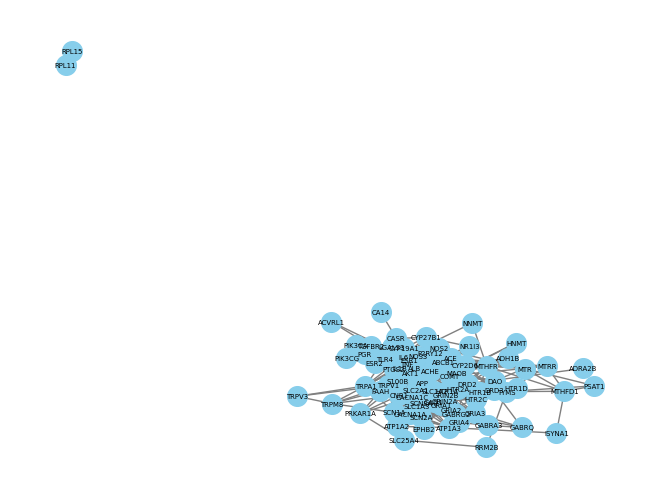

In [ ]:

G = nx.Graph()
G.add_edges_from(ppi_tuples)

# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue', font_size= 5, node_size=200, edge_color='gray')

# Display the graph
plt.show()


Find the connected components in the graph, number of nodes, and edges

In [ ]:
# Find connected components
components = list(nx.connected_components(G))

# Make a list of component sizes
component_sizes = [len(component) for component in components]

# Find connected components
components = list(nx.connected_components(G))

# Find the number of nodes, edges, and components in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
num_components = len(components)

# Print the number of nodes, edges, and components
print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Number of components:", num_components)

Number of nodes: 82
Number of edges: 543
Number of components: 2


Next, find the largest component and make a subgraph of this

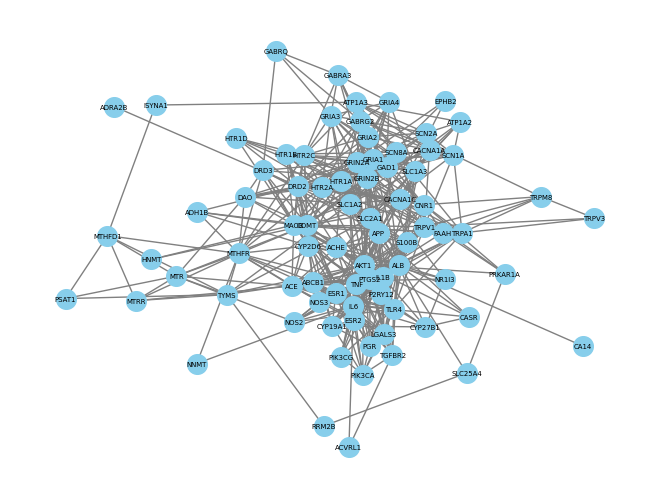

In [ ]:
largest_component = max(components, key=len)
G_sub = G.subgraph(largest_component)

nx.draw(G_sub, with_labels=True, node_color='skyblue', font_size= 5, node_size=200, edge_color='gray')
plt.show()


***

#### Centrality Measures

Next, I calculate various centrality measures, and make lists of the top 20 genes for each measure, writing each to a file for further analysis in STRING

***

##### Degree Centrality

In [ ]:
def calculate_and_write_degree_centrality(G_sub, output_file, top_n=20):

    degree_centrality = nx.degree_centrality(G_sub)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    top_n_genes = sorted_nodes[:top_n]

    with open(output_file, 'w') as file:
        for gene, centrality in top_n_genes:
            file.write(gene + '\n')

    print(f"Top {top_n} genes based on degree centrality have been written to {output_file}")

output_file = './OT_analysis/OT_degree_centrality_20.txt'
calculate_and_write_degree_centrality(G_sub, output_file)


Top 20 genes based on degree centrality have been written to ./OT_analysis/OT_degree_centrality_20.txt


***

##### Eigenvector Centrality

In [ ]:
def calculate_and_write_eigenvector_centrality(G_sub, output_file, top_n=20):

    eigenvector_centrality = nx.eigenvector_centrality(G_sub)
    sorted_nodes = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)
    top_n_genes = sorted_nodes[:top_n]

    # Write the top n genes to the output file
    with open(output_file, 'w') as file:
        for gene, centrality in top_n_genes:
            file.write(gene + '\n')

    print(f"Top {top_n} genes based on eigenvector centrality have been written to {output_file}")

output_file = './OT_analysis/OT_eigenvector_centrality_20.txt'
calculate_and_write_eigenvector_centrality(G_sub, output_file)


Top 20 genes based on eigenvector centrality have been written to ./OT_analysis/OT_eigenvector_centrality_20.txt


***

##### Degree Centrality  

In [ ]:
def calculate_and_write_degree_centrality(G_sub, output_file, top_n=20):
    degree_centrality = nx.degree_centrality(G_sub)
    sorted_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
    top_n_genes = sorted_nodes[:top_n]

    with open(output_file, 'w') as file:
        for gene, centrality in top_n_genes:
            file.write(gene + '\n')

    print(f"Top {top_n} genes based on degree centrality have been written to {output_file}")

output_file = './OT_analysis/OT_degree_centrality_20.txt'
calculate_and_write_degree_centrality(G_sub, output_file)


Top 20 genes based on degree centrality have been written to ./OT_analysis/OT_degree_centrality_20.txt


***

#### Cluster Analysis

Although I did my cluster analysis for the final project using Markov clustering (MCL) in STRING, below I calculate the clusters based on Louvain communities, and write these to a file for potential future analysis.  

In [ ]:
def write_communities_to_file(lv_communities, output_file):
    with open(output_file, 'w') as file:
        for community in lv_communities:
            file.write('-' * 20 + '\n')  # Add a separation line
            for gene in community:
                file.write(gene + '\n')
            file.write('\n')  # Add an empty line between communities
    print(f"Louvain_communities have been written to {output_file}")

lv_communities = nx.community.louvain_communities(G_sub, seed=123)
output_file = './OT_analysis/OT_communities.txt'
write_communities_to_file(lv_communities, output_file)



Louvain_communities have been written to ./OT_analysis/OT_communities.txt
